In [1]:
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
import os
import random

In [2]:
# Read the files in the Data Folder
files = os.listdir("Data/")
print(files)

# Generate the labels for each video class
labels = [i for i in range(len(files))]
print(labels)

['Bend', 'Jack', 'Jump', 'Pjump', 'Run', 'Side', 'Skip', 'Walk', 'Wave1', 'Wave2']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
# For illustration porposes read a video from the 
Data_path = "Data/"
video_path = Data_path + files[1]

Bend_videos = os.listdir(video_path)
print(Bend_videos[0])
Example_video = video_path+ "/" + Bend_videos[2]

clip1 = VideoFileClip(Example_video)

daria_jack.avi


In [8]:
clip1.ipython_display(width = 250)

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 51/52 [00:00<00:00, 357.81it/s]


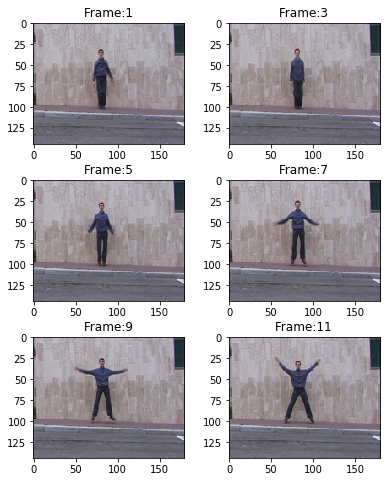

In [68]:
cap = cv2.VideoCapture(Example_video)

fig, axs = plt.subplots(3, 2, figsize = (7,8))
fig.subplots_adjust (hspace = 0.3, wspace = 0)
axs = axs.ravel()

counter = 0
frame_num = 0
for i in range(0,11):
    frame_num+=1
    ret,frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if i%2==0:
        axs[counter].imshow(frame, cmap = 'gray')
        axs[counter].set_title("Frame:" + str(frame_num))
        counter+=1
fig.savefig("Figures\Video.jpg", bbox_inches = 'tight')

In [59]:
# Read the video
cap = cv2.VideoCapture(Example_video)

# Video information
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("Number of frames:" + str(frameCount))
print("Hight:" + str(frameHight))
print("Width:" + str(frameWidth))

Number of frames:51
Hight:144
Width:180


In [60]:
# This function computes the optical flow for all the consequitive frames of the video
def optical_flow(cap):
    Flow = []
    ret, old_frame = cap.read()
    while True:
        ret, new_frame = cap.read()
        if ret:
            prvs = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
            new = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prvs, new, None,0.5, 3, 15, 3, 5, 1.2, 0)
            Flow.append(flow)
            old_frame = new_frame
        else:
            break
    return np.array(Flow)

In [61]:
Flow = optical_flow(cap)
print(Flow.shape)

(50, 144, 180, 2)


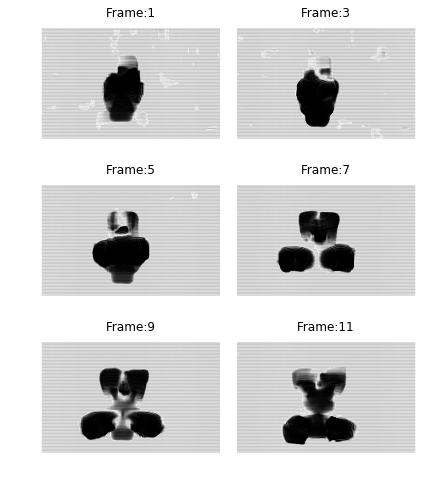

In [69]:
fig, axs = plt.subplots(3, 2, figsize = (7,8))
fig.subplots_adjust (hspace = 0.3, wspace = 0)
axs = axs.ravel()

counter = 0
frame_num = 0
for i in range(0,11):
    frame_num+=1
    if i%2==0:
        flow = Flow[i]
        u = flow[...,0]
        v = flow[...,1]
        axs[counter].axis('off')
        im =axs[counter].quiver(u,v,units='inches')
        axs[counter].set_title("Frame:" + str(frame_num))
        counter+=1
fig.savefig("Figures\optical_flow.jpg", bbox_inches = 'tight')

In [71]:
def optical_flow_amp(Flow):
    AMP = []
    for flow in Flow:
        u = flow[...,0] 
        v = flow[...,1]

        amp = np.sqrt(u**2 + v**2) 
        AMP.append(amp)
    return np.array(AMP)

In [72]:
amplitude = optical_flow_amp(Flow)

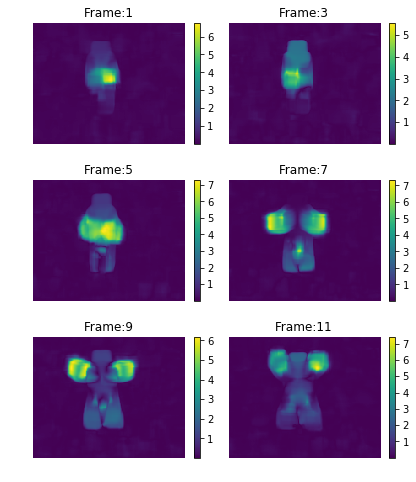

In [77]:
fig, axs = plt.subplots(3, 2, figsize = (7,8))
fig.subplots_adjust (hspace = 0.3, wspace = 0)
axs = axs.ravel()

counter = 0
frame_num = 0
for i in range(0,11):
    frame_num+=1
    if i%2==0:
        amp = amplitude[i]
        axs[counter].axis('off')
        im =axs[counter].imshow(amp)
        axs[counter].set_title("Frame:" + str(frame_num))
        fig.colorbar(im,ax = axs[counter])
        counter+=1
fig.savefig("Figures\motion_amplitude.jpg", bbox_inches = 'tight')

In [78]:
def amp_threshold(AMP):
    alpha = 0.1
    threshold = alpha * np.max(AMP)
    for i in range(len(AMP)):

        AMP[i][AMP[i]<threshold] = 0
        AMP[i][AMP[i]>=threshold] = 1
    return AMP

In [80]:
amplitude_thr = amp_threshold(amplitude)
print(amplitude_thr.shape)

(50, 144, 180)


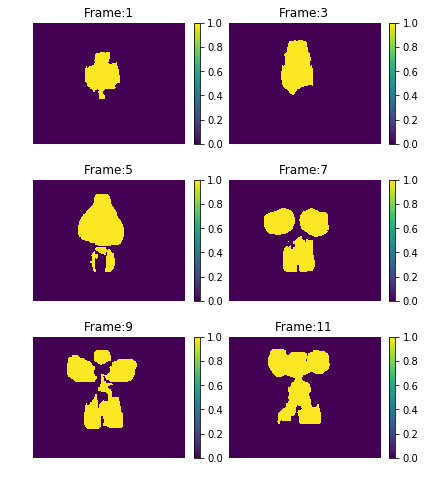

In [81]:
fig, axs = plt.subplots(3, 2, figsize = (7,8))
fig.subplots_adjust (hspace = 0.3, wspace = 0)
axs = axs.ravel()

counter = 0
frame_num = 0
for i in range(0,11):
    frame_num+=1
    if i%2==0:
        amp_thr = amplitude_thr[i]
        axs[counter].axis('off')
        im =axs[counter].imshow(amp_thr)
        axs[counter].set_title("Frame:" + str(frame_num))
        fig.colorbar(im,ax = axs[counter])
        counter+=1
fig.savefig("Figures\motion_region.jpg", bbox_inches = 'tight')

In [84]:
def MHI(amp_th):
    
    MHI_old = np.zeros((frameHight,frameWidth))
    MHI_new = np.zeros((frameHight,frameWidth))
    
    tau = frameCount-1
    for i in range(tau):
        if i == 0:
            MHI_old[amp_th[i] == 1] = tau
        else:
            MHI_new[amp_th[i] == 1] = tau
            MHI_new[amp_th[i] == 0] = np.maximum(MHI_old[amp_th[i] == 0]-1,0)

            MHI_old = MHI_new
    return MHI_new

In [85]:
MHI_image = MHI(amplitude_thr)

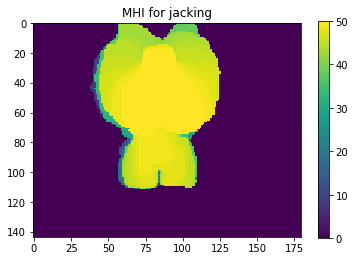

In [90]:
fig = plt.figure()
plt.imshow(MHI_image)
plt.title("MHI for jacking")
plt.colorbar()
plt.show()
fig.savefig("Figures/MHI_jacking.jpg", bbox_inches='tight')